In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms as trf
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report
from PIL import Image
import os
from glob import glob
import time
import copy

In [2]:
np.random.seed(32)
torch.manual_seed(42)

In [3]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if CUDA else "cpu")

In [5]:
df = pd.read_csv('../data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
lesion_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                for x in glob(os.path.join("..\\data", '*', '*.jpg'))}

In [7]:
df['path'] = df['image_id'].map(imageid_path.get)
df['cell_type'] = df['dx'].map(lesion_type.get)
df['target'] = pd.Categorical(df['cell_type']).codes

In [75]:
df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [76]:
df['target'].value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: target, dtype: int64

In [9]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,target
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\HAM10000\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\HAM10000\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\HAM10000\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\HAM10000\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\HAM10000\ISIC_0031633.jpg,Benign keratosis-like lesions,2


C:\Users\tomoto\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


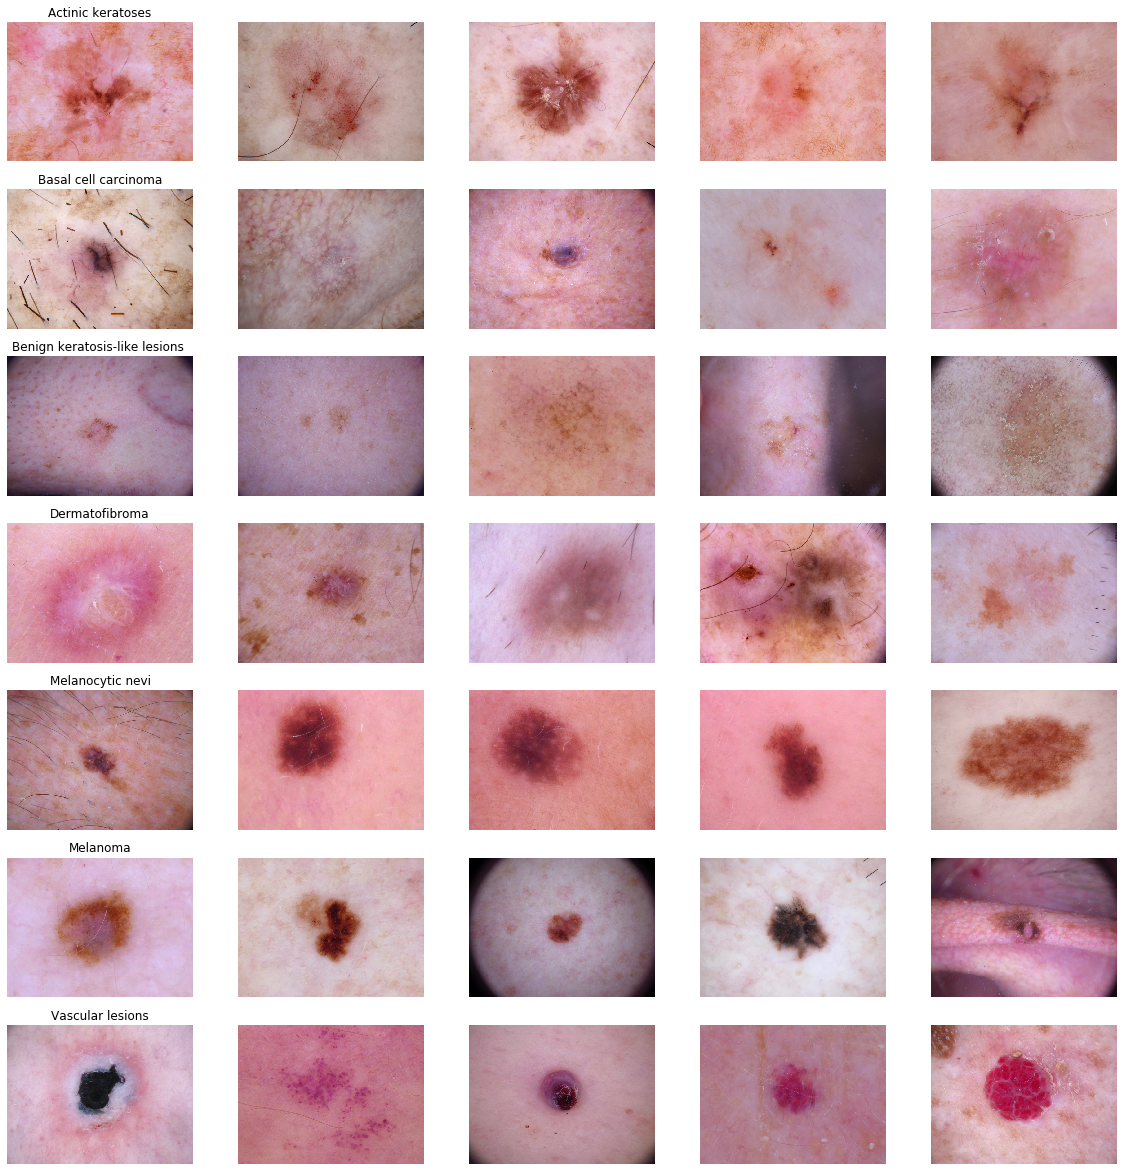

In [10]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=128).iterrows()):
        img = mpimg.imread(c_row['path'])
        c_ax.imshow(img)
        c_ax.axis('off')
fig.savefig('./output/category_samples.png', dpi=300)
fig.show()

In [11]:
class SkinData(data.Dataset):
    def __init__(self, df, transform=None):
        """Initialization"""
        self.df = df
        self.transform = transform
        
    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.df)
    
    def __getitem__(self, index):
        """Generates one sample of data"""
        # Load data and get label
        X = Image.open(self.df['path'][index]).resize((64, 64))
        y = torch.tensor(int(self.df['target'][index]))
        
        if self.transform:
            X = self.transform(X)
        
        return X, y

## Data Perparation

In [12]:
train, test = train_test_split(df, test_size=0.1)

In [13]:
validation, test = train_test_split(test, test_size=0.5)

In [14]:
train = train.reset_index()
validation = validation.reset_index()
test = test.reset_index()

## Train Model

In [48]:
def train_model(name, model, data_gen, val_gen, optimizer, criterion, num_epochs=20):
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    fpath = '../model/'
    trainings_error = []
    validation_error = []

    for epoch in range(num_epochs):
        if(epoch%5==0):
            print(f'Saving model...')
            torch.save(model.state_dict(), f'{fpath}_{name}_{epoch}_{time.time()}__.pth')
        print(f'Epoch {epoch} / {num_epochs-1}')
        print('--' * 4)
        trainings_err_tmp = []
        model.train()
        for data, label in data_gen:
            data_gpu = data.to(DEVICE)
            label_gpu = label.to(DEVICE)
            output = model(data_gpu)
            err = criterion(output, label_gpu)
            err.backward()
            optimizer.step()
            trainings_err_tmp.append(err.item())
        mean_trainings_error = np.mean(trainings_err_tmp)
        trainings_error.append(mean_trainings_error)
        print('trainings error:', mean_trainings_error)
            
        with torch.set_grad_enabled(False):
            val_err_tmp = []
            count_val = 0
            model.eval()
            for data, label in val_gen:
                data_gpu = data.to(DEVICE)
                label_gpu = label.to(DEVICE)
                output = model(data_gpu)
                err = criterion(output, label_gpu)
                val_err_tmp.append(err.item())
            mean_val_error = np.mean(val_err_tmp)
            validation_error.append(mean_val_error)
            print('validation error:', mean_val_error)
    del data_gpu
    del label_gpu
    time_since = time.time() - since
    print(f'Train completed in {time_since//60:.0f}m {time_since%60:.0f}s')
    torch.save(model.state_dict(), f'{fpath}_{name}_{num_epochs}_{time.time()}__.pth')
    return trainings_error, validation_error

## Predict

In [16]:
def predict(model, data_gen):
    results = []
    targets = []
    model.eval()
    with torch.no_grad():
        for data, label in data_gen:
            data_gpu = data.to(DEVICE)
            label_gpu = label.to(DEVICE)
            outputs = model(data_gpu)
            _, preds = torch.max(outputs,1)
            results.append(preds.item())
            targets.append(label.item())
    del data_gpu
    del label_gpu
    return results , targets

## Data augmentation

In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [18]:
composed = trf.Compose([trf.RandomHorizontalFlip(), trf.RandomVerticalFlip(), trf.CenterCrop(256),
                      trf.RandomCrop(224), trf.ToTensor(), trf.Normalize(mean=mean, std=std)])

## To Tensor

In [19]:
normalized = trf.Compose([trf.ToTensor(), trf.Normalize(mean=mean, std=std)])

## Loading Data

In [20]:
params = {
    'batch_size': 32,
    'shuffle': True
}

In [21]:
#Without augmentation
train_set_wo = SkinData(train, transform=normalized)
train_gen_wo = data.DataLoader(train_set_wo, **params)

val_set_wo = SkinData(validation, transform=normalized)
val_gen_wo = data.DataLoader(val_set_wo, **params)

In [22]:
#With augmentation
train_set_w = SkinData(train, transform=composed)
train_gen_w = data.DataLoader(train_set_w, **params)

val_set_w = SkinData(validation, transform=composed)
val_gen_w = data.DataLoader(val_set_w, **params)

# ResNet34

### **without augmentation**

In [23]:
res_net = models.resnet34(pretrained=True)
for param in res_net.parameters():
    param.require_grad = False

In [24]:
num_ftrs = res_net.fc.in_features
res_net.fc = nn.Linear(num_ftrs, 7)

In [25]:
res_net = res_net.to(DEVICE)

In [26]:
optimizer = torch.optim.Adam(res_net.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

In [27]:
train_loss_res_wo, val_loss_res_wo = train_model('ResNet', res_net, train_gen_wo, val_gen_wo, optimizer, criterion, 10)

Saving model...
Epoch 0 / 9
--------
trainings error: 2.0527610510376326
validation error: 1.2703907415270805
Epoch 1 / 9
--------
trainings error: 1.0132480621971982
validation error: 0.7759283594787121
Epoch 2 / 9
--------
trainings error: 0.6942460637354682
validation error: 0.6800067890435457
Epoch 3 / 9
--------
trainings error: 0.561203584814748
validation error: 0.6407485678792
Epoch 4 / 9
--------
trainings error: 0.4662568363631871
validation error: 0.6002762578427792
Saving model...
Epoch 5 / 9
--------
trainings error: 0.3945336581756037
validation error: 0.5706379190087318
Epoch 6 / 9
--------
trainings error: 0.32930431219068823
validation error: 0.5777467181906104
Epoch 7 / 9
--------
trainings error: 0.2570184770945116
validation error: 0.6028890199959278
Epoch 8 / 9
--------
trainings error: 0.1959542510832878
validation error: 0.5904452111572027
Epoch 9 / 9
--------
trainings error: 0.1474222982341939
validation error: 0.6496907062828541
Train completed in 22m 13s


In [28]:
train_loss_res_wo

[0.1474222982341939]

**Validation**

In [29]:
test_set = SkinData(test, transform=(normalized))
test_gen = data.DataLoader(test_set)

In [30]:
result_res_wo, target_res_wo = predict(res_net, test_gen)

In [31]:
del res_net
torch.cuda.empty_cache()

### **with augmentation**

In [32]:
res_net = models.resnet34(pretrained=True)
for param in res_net.parameters():
    param.require_grad = False

In [33]:
num_ftrs = res_net.fc.in_features
res_net.fc = nn.Linear(num_ftrs, 7)

In [34]:
res_net = res_net.to(DEVICE)

In [35]:
optimizer = torch.optim.Adam(res_net.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

In [36]:
train_loss_res_w, val_loss_res_w = train_model('ResNet_with_augment', res_net, train_gen_w, val_gen_w, optimizer, criterion, 10)

Saving model...
Epoch 0 / 9
--------
trainings error: 1.1392755225195106
validation error: 0.7863247655332088
Epoch 1 / 9
--------
trainings error: 0.76945782997084
validation error: 0.6890460848808289
Epoch 2 / 9
--------
trainings error: 0.674878754197283
validation error: 0.6316342242062092
Epoch 3 / 9
--------
trainings error: 0.6299804966923193
validation error: 0.6103713568300009
Epoch 4 / 9
--------
trainings error: 0.5937624304218495
validation error: 0.6018884368240833
Saving model...
Epoch 5 / 9
--------
trainings error: 0.5743013471364975
validation error: 0.5779999382793903
Epoch 6 / 9
--------
trainings error: 0.5587071600429555
validation error: 0.5659937523305416
Epoch 7 / 9
--------
trainings error: 0.5400318018299468
validation error: 0.5549429263919592
Epoch 8 / 9
--------
trainings error: 0.5297897079206527
validation error: 0.5606532301753759
Epoch 9 / 9
--------
trainings error: 0.5086005513972425
validation error: 0.5650829970836639
Train completed in 28m 36s


**Validation** 

In [37]:
result_res_w, target_res_w = predict(res_net, test_gen)

In [38]:
del res_net
torch.cuda.empty_cache()

# VGG11

### **without augmentation**

In [39]:
vgg_11 = models.vgg11(pretrained=True)
for param in vgg_11.parameters():
    param.require_grad = False

In [40]:
num_ftrs = vgg_11.classifier[6].in_features
features = list(vgg_11.classifier.children())[:-1]
features.extend([nn.Linear(num_ftrs, 7)])
vgg_11.classifier = nn.Sequential(*features)

In [41]:
vgg_11 = vgg_11.to(DEVICE)

In [42]:
optimizer = torch.optim.Adam(vgg_11.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

In [43]:
train_loss_vgg_wo, val_loss_vgg_wo = train_model('vgg', vgg_11, train_gen_wo, val_gen_wo, optimizer, criterion, 10)

Saving model...
Epoch 0 / 9
--------
trainings error: 1.08190208451545
validation error: 0.8129466064274311
Epoch 1 / 9
--------
trainings error: 0.8258494305695202
validation error: 0.8509423471987247
Epoch 2 / 9
--------
trainings error: 0.7656393825796479
validation error: 0.8780735060572624
Epoch 3 / 9
--------
trainings error: 0.7188991651678762
validation error: 0.7243785560131073
Epoch 4 / 9
--------
trainings error: 0.6622256033175381
validation error: 0.6690945141017437
Saving model...
Epoch 5 / 9
--------
trainings error: 0.5951579791222904
validation error: 0.6416097469627857
Epoch 6 / 9
--------
trainings error: 0.5454351600814373
validation error: 0.6196340192109346
Epoch 7 / 9
--------
trainings error: 0.502666099961345
validation error: 0.6251309383660555
Epoch 8 / 9
--------
trainings error: 0.47538765123549925
validation error: 0.5922457780689001
Epoch 9 / 9
--------
trainings error: 0.41984541386577257
validation error: 0.5827185325324535
Train completed in 20m 28s


**validation**

In [44]:
result_vgg_wo, target_vgg_wo = predict(vgg_11, test_gen)

In [45]:
del vgg_11
torch.cuda.empty_cache()

### **with augmentation**

In [46]:
vgg_11 = models.vgg11(pretrained=True)
for param in vgg_11.parameters():
    param.require_grad = False

In [49]:
num_ftrs = vgg_11.classifier[6].in_features
features = list(vgg_11.classifier.children())[:-1]
features.extend([nn.Linear(num_ftrs, 7)])
vgg_11.classifier = nn.Sequential(*features)

In [50]:
vgg_11 = vgg_11.to(DEVICE)

In [51]:
optimizer = torch.optim.Adam(vgg_11.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()

In [52]:
train_loss_vgg_w, val_loss_vgg_w = train_model('vgg_with_aug', vgg_11, train_gen_w, val_gen_w, optimizer, criterion, 10)

Saving model...
Epoch 0 / 9
--------
trainings error: 1.2396751502726941
validation error: 1.0671459399163723
Epoch 1 / 9
--------
trainings error: 0.9971659960264855
validation error: 0.9314696788787842
Epoch 2 / 9
--------
trainings error: 0.9129876688862524
validation error: 0.8738031275570393
Epoch 3 / 9
--------
trainings error: 0.8266584293005315
validation error: 0.8257730342447758
Epoch 4 / 9
--------
trainings error: 0.7756239303671721
validation error: 0.8034328147768974
Saving model...
Epoch 5 / 9
--------
trainings error: 0.7294271840905466
validation error: 0.7260586135089397
Epoch 6 / 9
--------
trainings error: 0.6931838377887476
validation error: 0.6706085987389088
Epoch 7 / 9
--------
trainings error: 0.6545450963238453
validation error: 0.7021510619670153
Epoch 8 / 9
--------
trainings error: 0.6346678733825684
validation error: 0.6662622541189194
Epoch 9 / 9
--------
trainings error: 0.6017026629642392
validation error: 0.6106642987579107
Train completed in 34m 8s


**validation**

In [53]:
result_vgg_w, target_vgg_w = predict(vgg_11, test_gen)

In [54]:
del vgg_11
torch.cuda.empty_cache()

## Release GPU memory

In [56]:
torch.cuda.empty_cache()

# Visualization

In [63]:
def plot_loss(train_loss, val_loss, title=None):
    plt.figure(figsize=(16,9))
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.title(title)
    plt.legend()
    name = f'./output/img_{time.time()}.png'
    plt.savefig(name, dpi=300)
    plt.show()

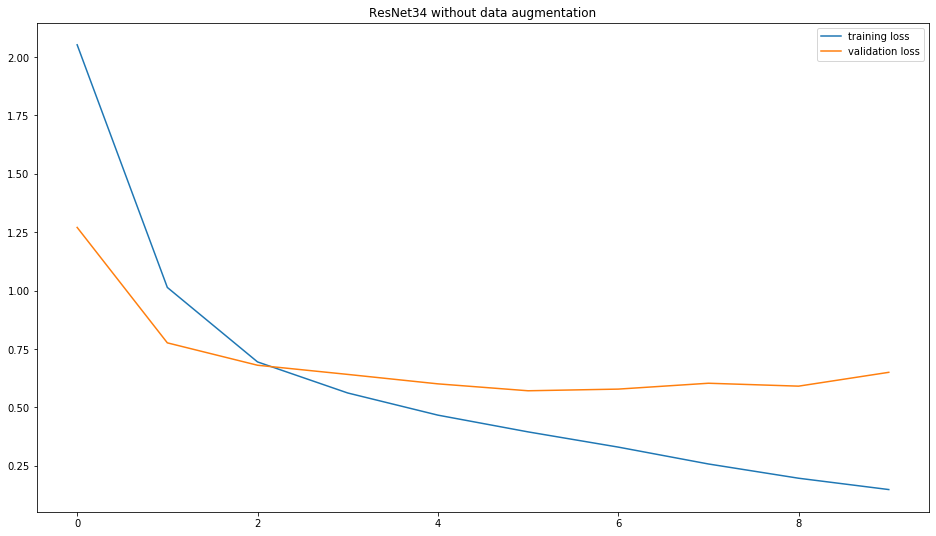

In [64]:
plot_loss(train_loss_res_wo, val_loss_res_wo, 'ResNet34 without data augmentation')

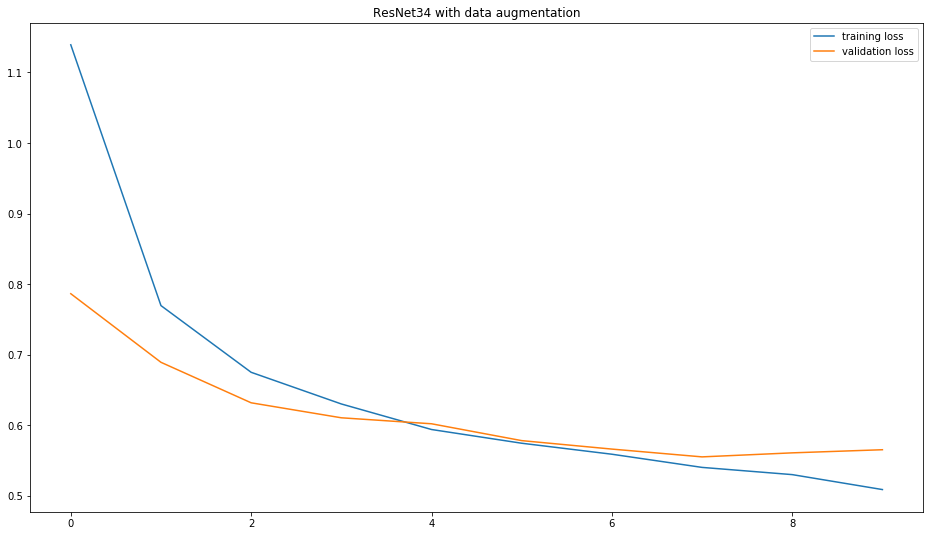

In [65]:
plot_loss(train_loss_res_w, val_loss_res_w, 'ResNet34 with data augmentation')

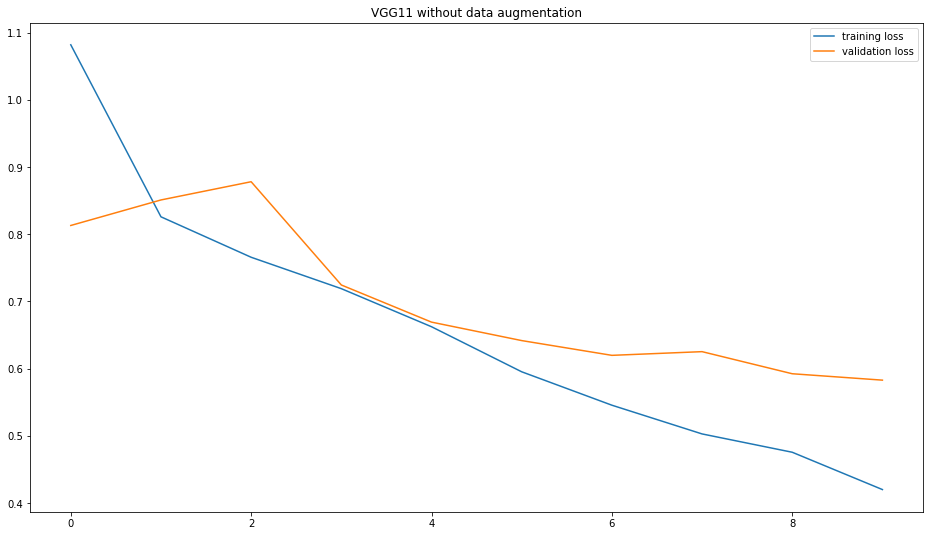

In [66]:
plot_loss(train_loss_vgg_wo, val_loss_vgg_wo, 'VGG11 without data augmentation')

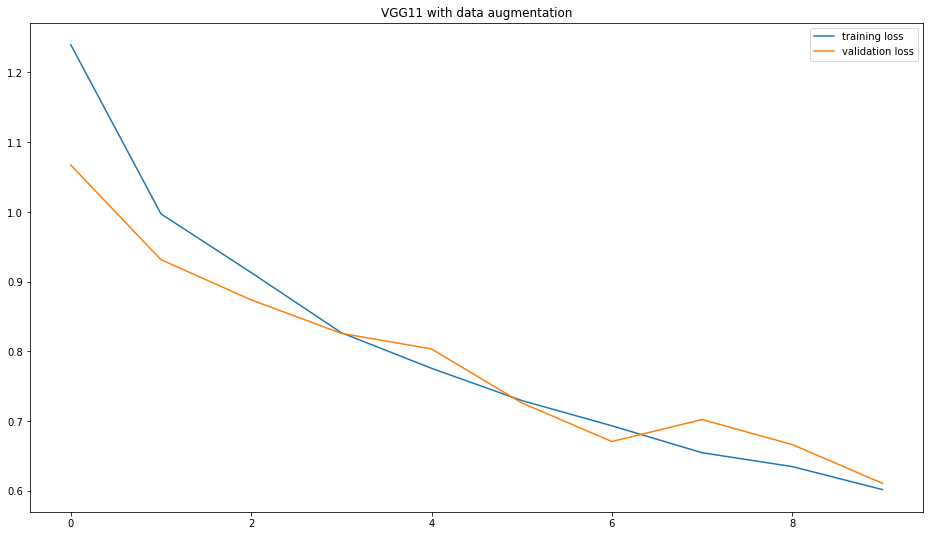

In [67]:
plot_loss(train_loss_vgg_w, val_loss_vgg_w, 'VGG11 with data augmentation')

# Result

In [72]:
print('== Accuracy==')
print(f'ResNet34 without Data Augmentation: {accuracy_score(target_res_wo, result_res_wo)}')
print(f'ResNet34 with Data Augmentation: {accuracy_score(target_res_w, result_res_w)}')
print(f'VGG11 without Data Augmentation: {accuracy_score(target_vgg_wo, result_vgg_wo)}')
print(f'VGG11 with Data Augmentation: {accuracy_score(target_vgg_w, result_vgg_w)}')

== Accuracy ==
ResNet34 without Data Augmentation: 81.0379241516966
ResNet34 with Data Augmentation: 55.08982035928144
VGG11 without Data Augmentation: 82.23552894211576
VGG11 with Data Augmentation: 73.45309381237524


In [69]:
res_report_wo = classification_report(target_res_wo, result_res_wo)
res_report_w = classification_report(target_res_w, result_res_w)
vgg_report_wo = classification_report(target_vgg_wo, result_vgg_wo)
vgg_report_w = classification_report(target_vgg_w, result_vgg_w)

C:\Users\tomoto\Anaconda3\envs\torch\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
#Save output values
np.savetxt('target_res_wo.txt', target_res_wo, delimiter=',')
np.savetxt('result_res_wo.txt', result_res_wo, delimiter=',')

np.savetxt('target_res_w.txt', target_res_w, delimiter=',')
np.savetxt('result_res_w.txt', result_res_w, delimiter=',')

np.savetxt('target_vgg_wo.txt', target_vgg_wo, delimiter=',')
np.savetxt('result_res_wo.txt', result_res_wo, delimiter=',')
, 
np.savetxt('target_vgg_w.txt', target_vgg_w, delimiter=',')
np.savetxt('result_vgg_w.txt', result_vgg_w, delimiter=',')

In [80]:
np.savetxt('train_loss_res_wo.txt', train_loss_res_wo, delimiter=',')
np.savetxt('val_loss_res_wo.txt', val_loss_res_wo, delimiter=',')

np.savetxt('val_loss_res_w.txt', val_loss_res_w, delimiter=',')
np.savetxt('train_loss_res_w.txt', train_loss_res_w, delimiter=',')

np.savetxt('train_loss_vgg_w.txt', train_loss_vgg_w, delimiter=',')
np.savetxt('val_loss_vgg_w.txt', val_loss_vgg_w, delimiter=',')

np.savetxt('train_loss_vgg_wo.txt', train_loss_vgg_wo, delimiter=',')
np.savetxt('val_loss_vgg_wo.txt', val_loss_vgg_wo, delimiter=',')